# Momentum, Volatility, and Volume Factors in U.S. Stock Returns

**ISYE 4031 Final Project**  
*Regression & Forecasting, Georgia Tech*

## Project Overview

This notebook analyzes the relationship between **momentum**, **volatility**, and **volume** factors in U.S. stock returns using S&P 500 data.

### Research Questions:
1. Do momentum indicators significantly predict future stock returns?
2. How does volatility clustering affect return predictability? 
3. Is trading volume a reliable indicator of price direction?

---

In [78]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import numpy as np
from bs4 import BeautifulSoup
import requests, re
import ta
from scipy import stats
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


### S&P 500 Stock List
We start by scraping the current S&P 500 stock list from a reliable financial data source.

**Data Source**: [Stock Analysis - S&P 500](https://stockanalysis.com/list/sp-500-stocks/)

**Key Information Collected**:
- Stock symbols (tickers)
- Market capitalization
___

In [79]:
url = 'https://stockanalysis.com/list/sp-500-stocks/'
resp = requests.get(url)
soup = BeautifulSoup(resp.text, 'html.parser')

# Find the table and extract headers
table = soup.find('table', class_='symbol-table svelte-1ro3niy')
headers = [th.get_text(strip=True) for th in table.find('tr').find_all('th')]

# Extract all row data
stocks_data = []
for row in table.find_all('tr')[1:]:  # Skip header row
    row_data = [cell.get_text(strip=True) for cell in row.find_all('td')]
    stocks_data.append(row_data)

# Create DataFrame and set No. column as index
sp500_df = pd.DataFrame(stocks_data, columns=headers)
sp500_df = sp500_df.set_index('No.')

### Stock Selection & Date Range Setup

**Stock Selection Process:**
- Extract first 50 companies from S&P 500 list for analysis
- Focus on established companies for reliable historical data

**Analysis Time Period:**
- **Start Date**: January 1, 2021
- **End Date**: December 27, 2024
- **Duration**: 4 years of market data
- **Purpose**: Capture post-pandemic market trends and recovery patterns

> **Note**: Using a subset of the top 50 stocks for computational efficiency and financial significance.
---

In [80]:
# Change this to 50 later, just 3 now for computing efficiency
num_stocks_chosen = 50

# Adding one to properly reflect the number of stocks chosen when it's 10 or more because of stocks with dots in their tickers being filtered out
num_stocks = num_stocks_chosen + 1 if num_stocks_chosen >= 10 else num_stocks_chosen

# Get the list of stock tickers from the DataFrame
stocks = sp500_df.head(num_stocks)['Symbol'].tolist()

# Filter out all tickers that contain dots (they often cause yfinance issues)
stocks = [ticker for ticker in stocks if '.' not in ticker and ticker not in ['COST', 'INTU']]

# Sort the list of stocks alphabetically
stocks.sort()

# Create start and end date variables for use later
startDate = dt.date(2021, 1, 1)
endDate = dt.date(2024, 12, 27)


# Print out list of stocks chosen and length of list
print(f"Selected stocks: {stocks}")
print(f"Total stocks: {len(stocks)}")

Selected stocks: ['AAPL', 'ABBV', 'ABT', 'AMAT', 'AMD', 'AMZN', 'APP', 'AVGO', 'AXP', 'BAC', 'CAT', 'CRM', 'CSCO', 'CVX', 'GE', 'GOOG', 'GOOGL', 'GS', 'HD', 'IBM', 'ISRG', 'JNJ', 'JPM', 'KO', 'LLY', 'LRCX', 'MA', 'MCD', 'META', 'MRK', 'MS', 'MSFT', 'MU', 'NFLX', 'NVDA', 'ORCL', 'PEP', 'PG', 'PLTR', 'PM', 'RTX', 'TMO', 'TMUS', 'TSLA', 'UNH', 'V', 'WFC', 'WMT', 'XOM']
Total stocks: 49


### Weekly Returns and Factor Calculation

**Objective**: Calculate weekly log returns and prepare data structure for technical indicator analysis.

**Key Metrics**:
- **Weekly Log Returns**: `ln(Close/Open) × 100` for price movement analysis
- **ROC** Rate of Change indicator for momentum analysis.
- **RVOL** Relative Volume indicator for volume analysis.
- **BBW** Bollinger Band width indicator for volatility analysis.

**Data Structure**:
- Multi-level columns for organized factor storage
- Separate columns for each technical indicator per stock
- Week numbering for time series tracking
---

**Download and extract relevant data on a weekly basis**

In [81]:
extended_date = startDate - dt.timedelta(days=80)

# Download weekly data
download = yf.download(
    tickers = stocks,
    start = extended_date,
    end = endDate,
    actions = False, threads = True, auto_adjust = True, rounding = True,
    group_by = 'tickers', 
    interval = '1d'
)

# Extract OCV data
open_data = download.xs('Open', level=1, axis=1)
close_data = download.xs('Close', level=1, axis=1)
volume_data = download.xs('Volume', level=1, axis=1)

# Convert daily to weekly data (Friday close) for analysis
weekly_open = open_data.resample('W-FRI').first()
weekly_close = close_data.resample('W-FRI').last()
weekly_volume = volume_data.resample('W-FRI').sum()

# Filter for display purposes
analysis_start = pd.Timestamp('2021-01-01')
analysis_mask = (weekly_close.index >= analysis_start)

analysis_open = weekly_open.loc[analysis_mask]
analysis_close = weekly_close.loc[analysis_mask]

[*********************100%***********************]  49 of 49 completed


**Create Dataframe with metric for each stock for each week**

In [82]:
# Create MultiIndex DataFrame (indexed by full weekly data for proper alignment)
columns = []
for ticker in stocks:
    # extend to include log return, ROC, RVOL, BBW for each ticker
    columns.extend([(ticker, 'Log_Return_%'), (ticker, 'ROC'), (ticker, 'RVOL'), (ticker, 'BBW')])
# Make sub-columns accessible
multi_columns = pd.MultiIndex.from_tuples(columns, names=['Ticker', 'Metric'])
# Construct df with weekly data indexed with ALL weekly dates (including lookback period)
weekly_data = pd.DataFrame(index=weekly_close.index, columns=multi_columns)

**Define a function to lag indicators by one week**

In [83]:
# Create function to lag indicators by one week. Returns values aligned with weekly_close.index
def lag_indicator(weekly_full):
    lagged_values = []
    for current_week in weekly_close.index:
        prev_week_candidates = weekly_full.index[weekly_full.index < current_week]
        if len(prev_week_candidates) > 0:
            prev_week = prev_week_candidates[-1]
            lagged_values.append(weekly_full.loc[prev_week])
        else:
            lagged_values.append(np.nan)
    return lagged_values

**Calculate and store key indicators**

In [84]:
# Calculate indicators for each stock using TA library
for ticker in stocks:

    # Get full daily time series for calculations (including lookback period)
    ticker_weekly_close = weekly_close[ticker].dropna()
    ticker_weekly_volume = weekly_volume[ticker].dropna()
    
    # 1. Log Returns (current week - already calculated from weekly data)
    # Calculate weekly log returns
    log_returns = (np.log(weekly_close / weekly_open) * 100).round(2)

    weekly_data[(ticker, 'Log_Return_%')] = log_returns[ticker]
    
    # 2. Rate of Change (ROC) - weekly-based 5-week ROC (weekly change_i / weekly change_{i-5}), lagged by 1 week
    # Use the DataFrame `weekly_roc_5w` and lag it by one week (we want t-1 values predicting t)

    # weekly_roc_5w: weekly_change_i divided by weekly_change_{i-5} (as percent)
    weekly_roc_5w = (((weekly_close - weekly_close.shift(5))/weekly_close.shift(5)) * 100).round(2)
    # Replace inf values with NaN (occurs when denominator is zero - no price movement in week i-5)
    weekly_roc_5w = weekly_roc_5w.replace([np.inf, -np.inf], np.nan)

    if ticker in weekly_roc_5w.columns:
        roc_weekly_lagged = weekly_roc_5w[ticker].reindex(weekly_close.index).shift(1)
    else:
        roc_weekly_lagged = pd.Series(np.nan, index=weekly_close.index)
    weekly_data[(ticker, 'ROC')] = roc_weekly_lagged.round(2)


    # 3. 36-day Bollinger Band Width (BBW) lagged by 1 week
    bb_indicator = ta.volatility.BollingerBands(close=ticker_weekly_close, window=7, window_dev=2)
    bb_upper = bb_indicator.bollinger_hband()
    bb_lower = bb_indicator.bollinger_lband()
    bb_mavg = bb_indicator.bollinger_mavg()
    
    # Calculate BBW as percentage width
    bbw_weekly_full = ((bb_upper - bb_lower) / bb_mavg) * 100
    bbw_lagged_values = lag_indicator(bbw_weekly_full)
    weekly_data[(ticker, 'BBW')] = pd.Series(bbw_lagged_values, index=weekly_close.index).round(2)

    # 4. Relative Volume (RVOL) - Current volume vs 50-day SMA using TA library, lagged by 1 week
    volume_sma_50d = ta.trend.SMAIndicator(close=ticker_weekly_volume, window=10).sma_indicator()
    rvol_weekly_full = ticker_weekly_volume / volume_sma_50d
    rvol_lagged_values = lag_indicator(rvol_weekly_full)
    weekly_data[(ticker, 'RVOL')] = pd.Series(rvol_lagged_values, index=weekly_close.index).round(2)


# Filter to analysis period only
weekly_data_analysis = weekly_data.loc[analysis_start:].copy()

# Add week numbers as a separate column
weekly_data_analysis.insert(0, 'Week', range(1, len(weekly_data_analysis) + 1))

print(f"Regression Format:")
print("Return_{{i,t}} = β_MOM×ROC_25d_{{i,t-1}} + β_BBW×BBW_36d_{{i,t-1}} + β_VOL×RVOL_50d_{{i,t-1}} + ε_{{i,t}}")


display(weekly_data_analysis)


Regression Format:
Return_{{i,t}} = β_MOM×ROC_25d_{{i,t-1}} + β_BBW×BBW_36d_{{i,t-1}} + β_VOL×RVOL_50d_{{i,t-1}} + ε_{{i,t}}


Ticker     Week         AAPL                             ABBV               \
Metric          Log_Return_%    ROC  RVOL    BBW Log_Return_%    ROC  RVOL   
Date                                                                         
2021-01-01    1        -0.97  12.48  0.83  16.54         3.32   2.40  0.38   
2021-01-08    2        -1.11  13.82  0.86  19.26         0.08   2.16  0.52   
2021-01-15    3        -1.60   8.02  1.21  18.23         4.33  -0.01  1.06   
2021-01-22    4         8.47   3.86  0.98  13.00        -0.36   5.15  1.09   
2021-01-29    5        -8.08   9.80  0.90  15.31        -6.84   7.38  0.72   
...         ...          ...    ...   ...    ...          ...    ...   ...   
2024-11-29  205         2.50  -2.07  0.80   6.54         3.28  -6.31  1.31   
2024-12-06  206         2.32   2.67  0.95   8.45        -3.40  -2.62  0.91   
2024-12-13  207         2.57   9.06  1.00  11.40        -1.28 -13.44  0.81   
2024-12-20  208         2.59   9.33  0.94  15.35         2.25 -13.10  0.92   
2024-12-27  209         1.65  13.10  1.63  17.47         2.21   6.42  1.38   

Ticker                     ABT  ...   WFC                 WMT               \
Metric        BBW Log_Return_%  ...  RVOL    BBW Log_Return_%    ROC  RVOL   
Date                            ...                                          
2021-01-01  10.49         0.48  ...  0.69  29.62         0.07  -4.13  0.93   
2021-01-08   8.17         1.88  ...  0.44  20.20         1.61  -4.58  0.74   
2021-01-15   5.64         0.48  ...  1.23  19.31        -0.93  -1.17  1.20   
2021-01-22   9.39         0.98  ...  1.44  19.41         1.17  -1.59  1.14   
2021-01-29  11.69         8.91  ...  0.71  19.63        -3.41   0.26  0.75   
...           ...          ...  ...   ...    ...          ...    ...   ...   
2024-11-29  26.06         0.41  ...  0.91  32.03         2.19  11.24  1.63   
2024-12-06  26.08        -2.69  ...  0.88  30.21         3.06  12.12  0.95   
2024-12-13  27.27        -2.00  ...  0.93  27.24        -1.26  16.44  1.28   
2024-12-20  28.61         1.36  ...  0.79  21.86        -2.34  11.36  1.09   
2024-12-27  22.18         1.11  ...  1.39  13.83         1.40   9.72  1.64   

Ticker                     XOM                      
Metric        BBW Log_Return_%    ROC  RVOL    BBW  
Date                                                
2021-01-01   6.60        -1.12  12.62  0.50  26.64  
2021-01-08   7.05         9.21   2.56  0.61  19.66  
2021-01-15   6.46         6.14   9.04  1.13  15.47  
2021-01-22   4.41        -2.12   9.33  1.23  20.82  
2021-01-29   3.45        -4.48  11.03  0.73  22.52  
...           ...          ...    ...   ...    ...  
2024-11-29  15.06        -2.90   2.32  0.93   8.63  
2024-12-06  18.81        -3.87  -0.47  0.91   7.49  
2024-12-13  22.65        -3.37  -0.39  1.11   9.62  
2024-12-20  22.43        -4.01  -7.72  1.43  12.77  
2024-12-27  18.39         1.12 -11.27  1.55  18.47  

[209 rows x 197 columns]

**Function creating dataframe with each week's metrics**

In [85]:
# Get unique ticker names from the MultiIndex columns. First one is 'Week' so skip it
stock_tickers = weekly_data_analysis.columns.get_level_values('Ticker').unique().tolist()
stock_tickers = [ticker for ticker in stock_tickers if ticker != 'Week']

# Create dataframe for week data where row is stock ticker and columns are metrics
def get_week_x_data(tickers, week_number):
    week_data = pd.DataFrame(index=tickers, columns=['Log_Return_%', 'ROC', 'RVOL', 'BBW'])
    
    index = week_number - 1  # Convert to zero-based index
    
    for ticker in tickers:
        # Access each metric individually from the MultiIndex DataFrame
        week_data.loc[ticker, 'Log_Return_%'] = weekly_data_analysis[(ticker, 'Log_Return_%')].iloc[index]
        week_data.loc[ticker, 'ROC'] = weekly_data_analysis[(ticker, 'ROC')].iloc[index]
        week_data.loc[ticker, 'RVOL'] = weekly_data_analysis[(ticker, 'RVOL')].iloc[index]
        week_data.loc[ticker, 'BBW'] = weekly_data_analysis[(ticker, 'BBW')].iloc[index]
    
    # Drop row if NaN found in any column
    week_data_clean = week_data.dropna(subset=['Log_Return_%', 'ROC', 'RVOL', 'BBW'])
    return week_data_clean

In [86]:
# Output
week_num = np.random.randint(1, 209)
week_result = get_week_x_data(stock_tickers, week_num)
print(f"Week {week_num} data:")
display(week_result.head())

Week 55 data:


,Log_Return_%,ROC,RVOL,BBW
AAPL,2.33,6.38,1.04,18.33
ABBV,1.61,13.48,1.16,22.21
ABT,-4.69,4.06,1.19,14.21
AMAT,12.26,3.41,0.94,13.09
AMD,5.87,-8.34,1.14,18.91


In [97]:
from scipy import stats

def remove_outliers(df, columns=['ROC', 'RVOL', 'BBW', 'Log_Return_%'], threshold=3):
    """
    Removes rows where any column value is > 3 Standard Deviations from the mean.
    Prints the percentage of data removed to help you monitor data quality.
    """
    df_clean = df.copy()
    
    # Calculate Z-Scores for the relevant columns
    z_scores = np.abs(stats.zscore(df_clean[columns]))
    
    # Create a mask: Keep rows where ALL z-scores are less than the threshold (e.g., 3)
    mask = (z_scores < threshold).all(axis=1)
    
    # Filter the data
    df_final = df_clean[mask]
    
    # Calculate stats
    rows_before = len(df)
    rows_after = len(df_final)
    rows_removed = rows_before - rows_after
    pct_removed = (rows_removed / rows_before) * 100
    
    # Optional: Print status only if outliers are found to reduce clutter in loops
    if rows_removed > 0:
        print(f"Outliers removed: {rows_removed} rows ({pct_removed:.1f}%)")
        
    return df_final


**Run multiple linear regression for a given week**

In [ ]:
# Model for one week
import statsmodels.api as sm

week_num = 4
week_result = get_week_x_data(stock_tickers, week_num)
y = week_result['Log_Return_%'].values.astype(float)
X = week_result[['ROC', 'RVOL', 'BBW']].values.astype(float)
model = sm.OLS(y,X).fit()

print("Week Number: ", week_num)
print(model.summary())

Week Number:  4
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.280
Model:                            OLS   Adj. R-squared (uncentered):              0.232
Method:                 Least Squares   F-statistic:                              5.837
Date:                Mon, 01 Dec 2025   Prob (F-statistic):                     0.00186
Time:                        20:35:44   Log-Likelihood:                         -137.62
No. Observations:                  48   AIC:                                      281.2
Df Residuals:                      45   BIC:                                      286.9
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

**Collect regression coefficients and model diagnostics for analysis**

In [88]:
# Create a function to run regression for each week and store results in a DataFrame
def run_weekly_regression(tickers, weekly_data_analysis):
    regression_results = []
    
    for week_num in range(1, len(weekly_data_analysis) + 1):
        week_data = get_week_x_data(tickers, week_num)
        
        y = week_data['Log_Return_%'].values.astype(float)
        X = week_data[['ROC', 'RVOL', 'BBW']].values.astype(float)
        X = sm.add_constant(X)  # Add intercept column
        
        model = sm.OLS(y, X).fit()
        
        regression_results.append({
            'Week': week_num,
            'Intercept': model.params[0],
            'Beta ROC': model.params[1],
            'Beta RVOL': model.params[2],
            'Beta BBW': model.params[3],
            'R-squared': model.rsquared,
            'ROC significance' : 'Significant' if model.pvalues[1] < 0.05 else 'Not Significant',
            'RVOL significance' : 'Significant' if model.pvalues[2] < 0.05 else 'Not Significant',
            'BBW significance' : 'Significant' if model.pvalues[3] < 0.05 else 'Not Significant',
            'A-D normality' : 'Reject Normality' if stats.anderson(model.resid)[0] < stats.anderson(model.resid)[1][2] else 'Fail to Reject Normality'
        })
    
    return pd.DataFrame(regression_results)

regression_results_df = run_weekly_regression(stock_tickers, weekly_data_analysis)
print("Weekly Regression Results:")
display(regression_results_df)

avg_betas = regression_results_df[['Beta ROC', 'Beta RVOL', 'Beta BBW', 'R-squared']].mean()
print("Average Betas across all weeks:")
print(avg_betas)

Weekly Regression Results:


,Week,Intercept,Beta ROC,Beta RVOL,Beta BBW,R-squared,ROC significance,RVOL significance,BBW significance,A-D normality
0,1,3.308362,-0.043027,-1.744514,-0.092720,0.276571,Not Significant,Not Significant,Not Significant,Fail to Reject Normality
1,2,1.470807,0.019638,-4.338520,0.227358,0.235035,Not Significant,Not Significant,Significant,Reject Normality
2,3,-2.791825,-0.085869,0.623650,0.169180,0.059782,Not Significant,Not Significant,Not Significant,Reject Normality
3,4,1.194740,-0.474176,-2.808103,0.368509,0.251173,Significant,Not Significant,Significant,Reject Normality
4,5,-2.851821,-0.190294,-0.249848,0.020172,0.143317,Not Significant,Not Significant,Not Significant,Fail to Reject Normality
...,...,...,...,...,...,...,...,...,...,...
204,205,-3.218901,-0.015219,3.919426,-0.021214,0.220479,Not Significant,Significant,Not Significant,Reject Normality
205,206,1.306573,-0.036646,-4.132657,0.180751,0.414074,Not Significant,Not Significant,Significant,Reject Normality
206,207,-0.324184,-0.037640,-0.023138,-0.023743,0.065131,Not Significant,Not Significant,Not Significant,Fail to Reject Normality
207,208,-1.872773,0.009224,-1.484338,0.065476,0.100676,Not Significant,Not Significant,Not Significant,Reject Normality


Average Betas across all weeks:
Beta ROC    -0.004500
Beta RVOL   -0.342186
Beta BBW     0.008920
R-squared    0.186242
dtype: float64


**Perform regression diagnostics**

In [89]:
# Calculate percentage of weeks with significant beta values for each indicator
count_ROC_significance = (regression_results_df['ROC significance'] == 'Significant').sum()
count_RVOL_significance = (regression_results_df['RVOL significance'] == 'Significant').sum()
count_BBW_significance = (regression_results_df['BBW significance'] == 'Significant').sum()

percent_significant_ROC = (count_ROC_significance / len(regression_results_df)) * 100
percent_significant_RVOL = (count_RVOL_significance / len(regression_results_df)) * 100
percent_significant_BBW = (count_BBW_significance / len(regression_results_df)) * 100

print(f"Percent of weeks with significant ROC beta: {percent_significant_ROC:.2f}%")
print(f"Percent of weeks with significant RVOL beta: {percent_significant_RVOL:.2f}%")
print(f"Percent of weeks with significant BBW beta: {percent_significant_BBW:.2f}%")

Percent of weeks with significant ROC beta: 22.97%
Percent of weeks with significant RVOL beta: 14.35%
Percent of weeks with significant BBW beta: 35.89%


**Find Type I and II Error**

In [90]:
alpha = 0.05
type_I_errors = 1- (1-alpha)**3
print(type_I_errors)
print(f"There is an approximately {type_I_errors*100:.2f}% chance that we will incorrectly reject the null hypothesis that all beta values are equal to zero.")

0.1426250000000001
There is an approximately 14.26% chance that we will incorrectly reject the null hypothesis that all beta values are equal to zero.


**Graph QQ plot for a given week**

QQ Plot for Week 174 Residuals:


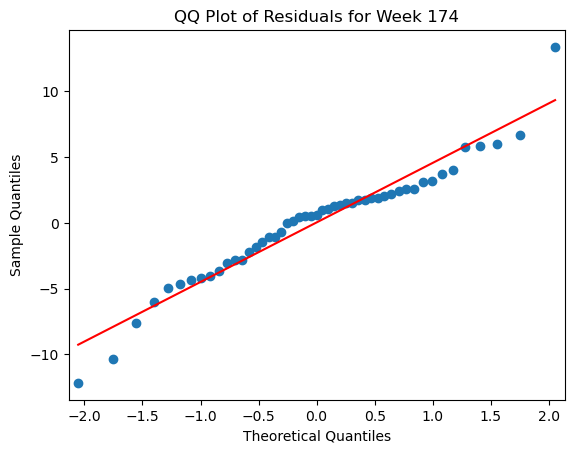

Due to the QQ plot showing that the residuals closely follow the reference line,
 we can conclude that the residuals are approximately normally distributed.
 This suggests that the assumption of normality for the residuals in our regression model is met.
Sum of Squared Errors (SSE) for QQ plot: 565.3433
R-squared for QQ plot: 0.9528218805820645


In [91]:
# QQ plot for a given week
week_num = np.random.randint(1, 209)
week_data = get_week_x_data(stock_tickers, week_num)


####### here model is still referring to model as it was defined earlier. redefine model.
# residuals = model.resid 

y = week_data['Log_Return_%'].values.astype(float)
X = week_data[['ROC', 'RVOL', 'BBW']].values.astype(float)
model = sm.OLS(y, X).fit()
residuals = model.resid

# print(residuals)
print(f"QQ Plot for Week {week_num} Residuals:")

# QQ Plot line ='r'
fig = plt.figure()
ax = fig.add_subplot(111)
fig = sm.qqplot(residuals, line ='r', ax = ax);
ax.set_title(f'QQ Plot of Residuals for Week {week_num}')
plt.show()

print("Due to the QQ plot showing that the residuals closely follow the reference line," \
"\n we can conclude that the residuals are approximately normally distributed." \
"\n This suggests that the assumption of normality for the residuals in our regression model is met.")

# Sum of Squared Errors of QQ plot
theoretical_quantiles = np.sort(stats.norm.ppf((np.arange(1, len(residuals) + 1) - 0.5) / len(residuals)))
sample_quantiles = np.sort(residuals)
sse_qq_plot = np.sum((theoretical_quantiles - sample_quantiles) ** 2)
print(f"Sum of Squared Errors (SSE) for QQ plot: {sse_qq_plot:.4f}")

r = np.corrcoef(theoretical_quantiles, sample_quantiles)[0, 1]
r_squared = r ** 2
print(f"R-squared for QQ plot: {r_squared}")

**Variance Inflation Factor for a given week**

In [92]:
# VIF Calculation for one week
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Indicator"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data
X_vif = week_result[['ROC', 'RVOL', 'BBW']].astype(float)
vif_results = calculate_vif(X_vif)
print("VIF Results:")
display(vif_results)

print("None of the VIF values exceed 10, indicating that multicollinearity is not a concern among the predictors.")

VIF Results:


,Indicator,VIF
0,ROC,3.626409
1,RVOL,4.329363
2,BBW,8.861938


None of the VIF values exceed 10, indicating that multicollinearity is not a concern among the predictors.


**Create scatterplot of Rate of Change vs Log Return for a given week**

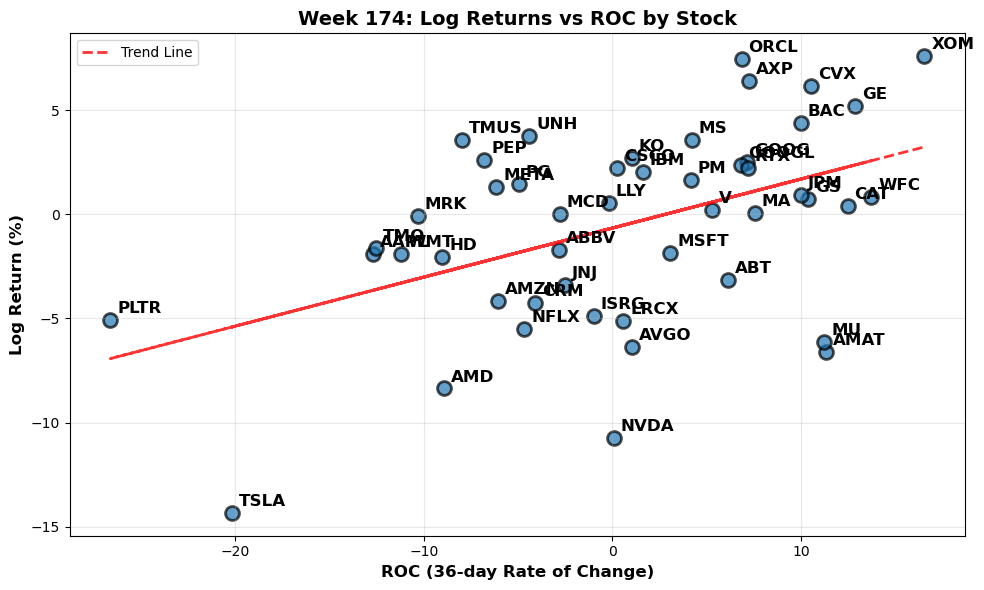

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract week 10 data to ensure non-NaN values
week_data = weekly_data_analysis.iloc[9]  # Week 10 (0-indexed)

# Prepare data for scatter plot
plot_data = []
for ticker in stocks:
    log_return = week_data[(ticker, 'Log_Return_%')]
    roc = week_data[(ticker, 'ROC')]
    
    # Only include if both values are not NaN
    if pd.notna(log_return) and pd.notna(roc):
        plot_data.append({
            'Ticker': ticker,
            'Log_Return_%': log_return,
            'ROC': roc
        })

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(plot_df['ROC'], plot_df['Log_Return_%'], 
           s=100, alpha=0.7, edgecolors='black', linewidth=2)

# Add labels for each point
for i, row in plot_df.iterrows():
    plt.annotate(row['Ticker'], 
                (row['ROC'], row['Log_Return_%']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=12, fontweight='bold')

plt.xlabel('ROC (36-day Rate of Change)', fontsize=12, fontweight='bold')
plt.ylabel('Log Return (%)', fontsize=12, fontweight='bold')
plt.title(f'Week {week_num}: Log Returns vs ROC by Stock', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add a trend line if we have data
if len(plot_df) > 1:
    z = np.polyfit(plot_df['ROC'], plot_df['Log_Return_%'], 1)
    p = np.poly1d(z)
    plt.plot(plot_df['ROC'], p(plot_df['ROC']), 
             "r--", alpha=0.8, linewidth=2, label=f'Trend Line')
    plt.legend()

plt.tight_layout()
plt.show()

In [94]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# display(week_result)

# Clean the data by replacing inf and -inf values with NaN, then drop NaN rows
week_result_clean = week_result.replace([np.inf, -np.inf], np.nan).infer_objects(copy=False).dropna()

print(f"Original data shape: {week_result.shape}")
print(f"Cleaned data shape: {week_result_clean.shape}")

# Create pairplot for the cleaned week result with trend lines in each scatter plot
# sns.pairplot(week_result_clean, kind='scatter', plot_kws={'alpha': 1})
sns.pairplot(week_result_clean, kind='reg', plot_kws={'scatter_kws': {'alpha': 0.7, 's': 5}}, 
             diag_kind='hist')
plt.show()

TypeError: NDFrame.infer_objects() got an unexpected keyword argument 'copy'

## Durbin Watson Test ##

Durbin-Watson Statistics per Week:


,Week,Durbin-Watson Statistic
0,1,2.162250
1,2,1.751366
2,3,2.404646
3,4,1.914954
4,5,2.088636
...,...,...
204,205,1.537430
205,206,1.924913
206,207,2.082587
207,208,1.860859


Average Durbin-Watson Statistic across all weeks: 1.9307


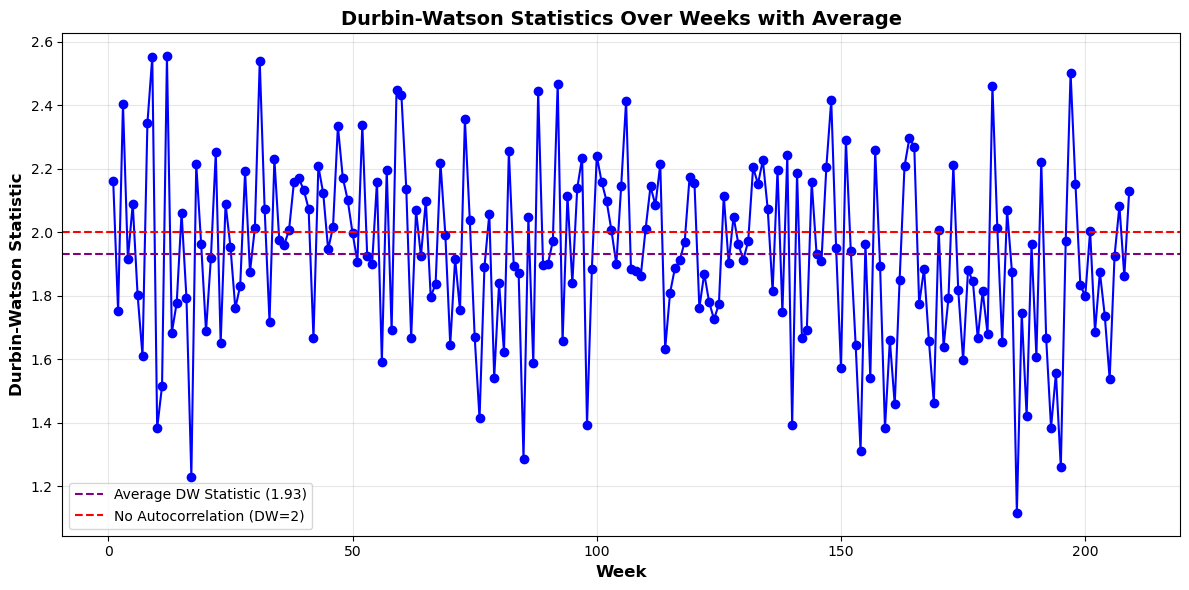

In [ ]:
from statsmodels.stats.stattools import durbin_watson
# Create dataframe for each week and DW Statistic
def get_durbin_watson_per_week(tickers, weekly_data_analysis):
    dw_results = []
    
    for week_num in range(1, len(weekly_data_analysis) + 1):
        week_data = get_week_x_data(tickers, week_num)
        
        y = week_data['Log_Return_%'].values.astype(float)
        X = week_data[['ROC', 'RVOL', 'BBW']].values.astype(float)
        X = sm.add_constant(X)  # Add intercept column
        
        model = sm.OLS(y, X).fit()
        
        dw_stat = durbin_watson(model.resid)
        
        dw_results.append({
            'Week': week_num,
            'Durbin-Watson Statistic': dw_stat
        })
    
    dw_results = pd.DataFrame(dw_results)
    return dw_results

dw_results_df = get_durbin_watson_per_week(stock_tickers, weekly_data_analysis)
print("Durbin-Watson Statistics per Week:")
display(dw_results_df)

average_dw_statistic = dw_results_df['Durbin-Watson Statistic'].mean()
print(f"Average Durbin-Watson Statistic across all weeks: {average_dw_statistic:.4f}")

# Plot all DW statistics with Average line
plt.figure(figsize=(12, 6))
plt.plot(dw_results_df['Week'], dw_results_df['Durbin-Watson Statistic'], marker='o', linestyle='-', color='b')
plt.axhline(y=average_dw_statistic, color='purple', linestyle='--', label=f'Average DW Statistic ({average_dw_statistic:.2f})')
plt.axhline(y=2, color='r', linestyle='--', label='No Autocorrelation (DW=2)')
plt.title('Durbin-Watson Statistics Over Weeks with Average', fontsize=14, fontweight='bold')
plt.xlabel('Week', fontsize=12, fontweight='bold')
plt.ylabel('Durbin-Watson Statistic', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#### Time Series Regression for Factor Significance

**Time series for each factor**

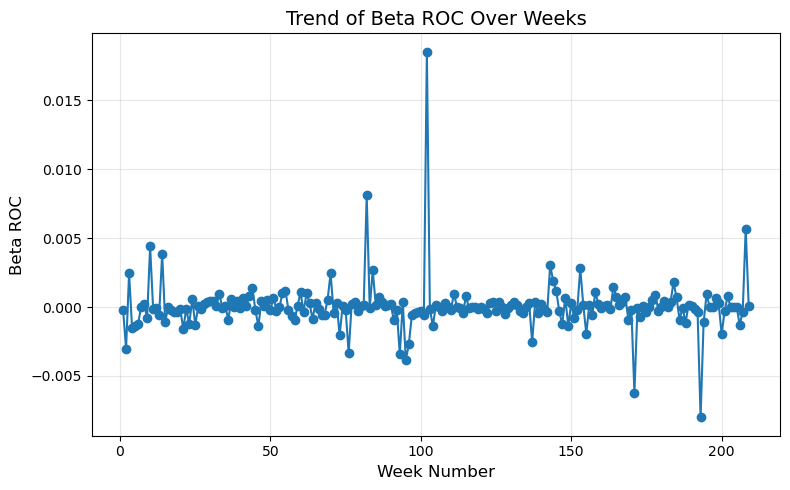

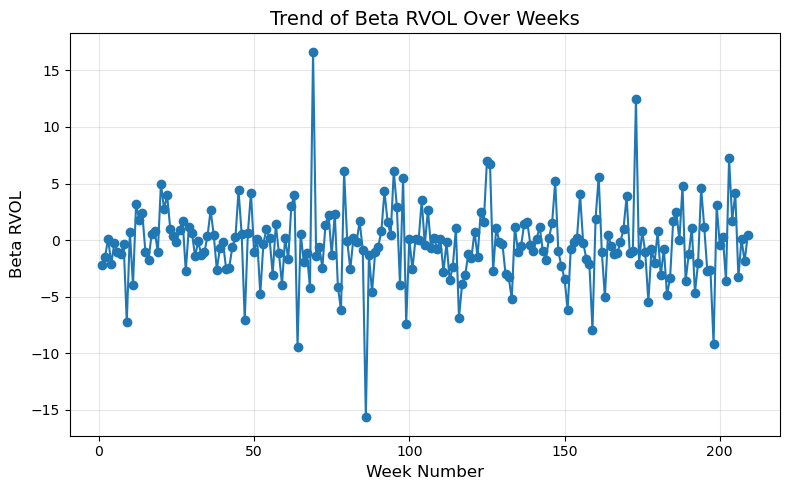

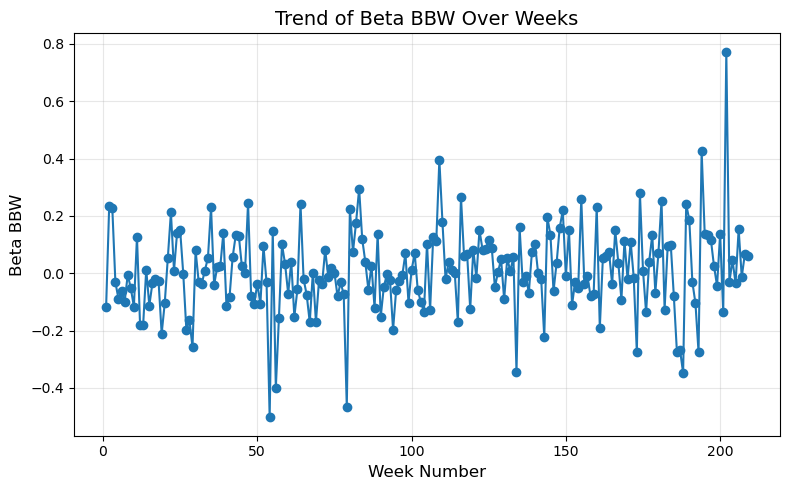

In [ ]:
for factor in regression_results_df.columns[2:5]:  # Skip week column, skip intercept column since in MLR it has no practical meaning
    plt.figure(figsize=(8, 5))
    plt.plot(regression_results_df['Week'], regression_results_df[factor], marker='o', linestyle='-')
    plt.title(f'Trend of {factor} Over Weeks', fontsize=14)
    plt.xlabel('Week Number', fontsize=12)
    plt.ylabel(factor, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


**Factor return**

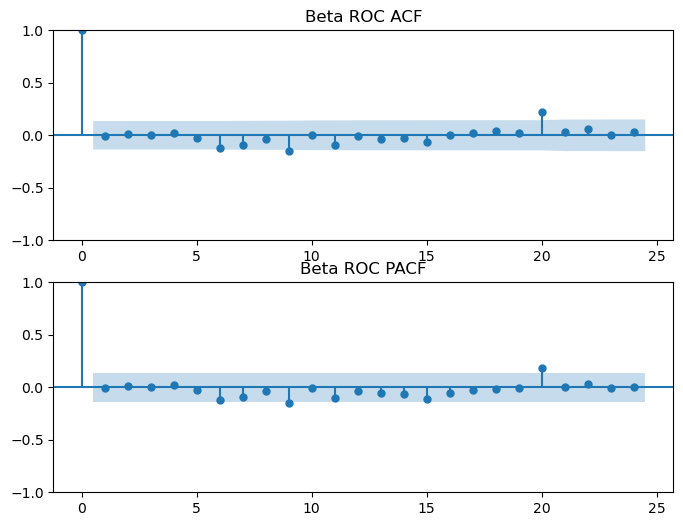

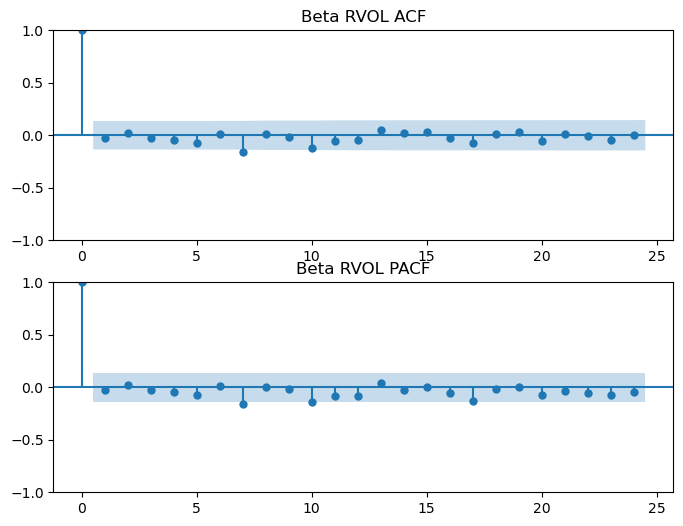

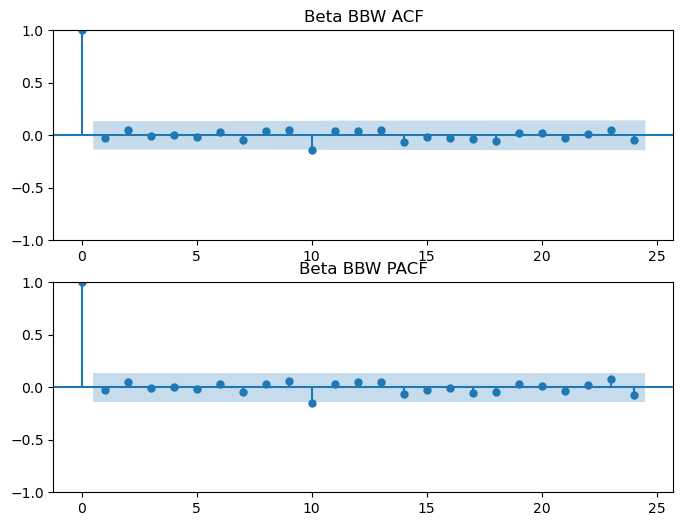

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-2015.005, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2023.005, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-2021.013, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-2020.994, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-2018.989, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2021.185, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.178 seconds

Best model for Beta_ROC:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  209
Model:                        SARIMAX   Log Likelihood                1012.503
Date:                Mon, 01 Dec 2025   AIC                          -2023.005
Time:                        19:50:47   BIC                          -2019.663
Sample:                             0   HQIC             

/Users/pedro/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/pedro/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1110.349, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1110.351, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1111.859, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1108.014, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1109.887, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1109.892, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1111.403, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.145 seconds

Best model for Beta_RVOL:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  209
Model:                        SARIMAX   Log Likelihood                -552.007
Date:                Mon, 01 Dec 2025   AIC                           1108.014
Time:                        19:50:47   BIC                           1114.698
Sample:                             0  

In [ ]:
# Should we check for/handle autocorrelation before doing factor analysis?

# Checking to see which kind of model is most appropriate for each factor


beta_roc = regression_results_df['Beta ROC']
beta_rvol = regression_results_df['Beta RVOL']
beta_bbw = regression_results_df['Beta BBW']


# Function to graph acf and pacf for each factor
def show_acf_pacf(series, title):
    fig, ax = plt.subplots(2,1,figsize  =(8,6))

    plot_acf(series, ax = ax[0])
    ax[0].set_title(f"{title} ACF")

    plot_pacf(series, ax = ax[1], method = 'ywm')
    ax[1].set_title(f"{title} PACF")

    plt.tight_layout
    plt.show()

show_acf_pacf(beta_roc, "Beta ROC")
show_acf_pacf(beta_rvol, "Beta RVOL")
show_acf_pacf(beta_bbw, "Beta BBW")


# Function to pick the best model for each factor
def pick_model(series, title):
    model = auto_arima(
        series,
        seasonal=False,
        stepwise=True,
        max_p=5, max_q=5,
        d=0,  # assume stationarity first
        trace=True
    )
    print(f"\nBest model for {title}: {model.summary()}\n")

pick_model(beta_roc,  "Beta_ROC")
pick_model(beta_rvol, "Beta_RVOL")
pick_model(beta_bbw,  "Beta_BBW")

**Determined that ARIMA(0,0,0) is best for all factors. Define time series regression models**

In [ ]:
def factor_avg_return(factor):
    X = sm.add_constant([1] * len(factor)) # constant term
    model = sm.OLS(factor, X).fit()
    return model

for factor in regression_results_df.columns[2:5]: # factor columns
    model = factor_avg_return(regression_results_df[factor])
    print(f"Factor Return Model for {factor}:")
    print(model.summary())

Factor Return Model for Beta ROC:
                            OLS Regression Results                            
Dep. Variable:               Beta ROC   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 01 Dec 2025   Prob (F-statistic):                nan
Time:                        19:50:47   Log-Likelihood:                 1012.6
No. Observations:                 209   AIC:                            -2023.
Df Residuals:                     208   BIC:                            -2020.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.578e

**Run autocorrelation test to determine if past factor returns can predict future factor returns**

In [ ]:
def factor_autocorrelation(factor):
    model = sm.tsa.ARIMA(factor, order = (1,0,0)) # ar(1) model for autocorrelation
    return model


for factor in regression_results_df.columns[2:5]: # factor columns
    model = factor_autocorrelation(regression_results_df[factor]).fit()
    print(f"Factor Autocorrelation Model for {factor}:")
    print(model.summary())

Factor Autocorrelation Model for Beta ROC:
                               SARIMAX Results                                
Dep. Variable:               Beta ROC   No. Observations:                  209
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1012.597
Date:                Mon, 01 Dec 2025   AIC                          -2019.195
Time:                        19:50:47   BIC                          -2009.168
Sample:                             0   HQIC                         -2015.141
                                - 209                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.438e-05      0.000      0.302      0.762      -0.000       0.000
ar.L1         -0.0069      0.184     -0.038      0.970      -0.367       0.353
sigma2   

#### Simple Exponential Smoothing

Define a function that splits the data into a training and test set, finds optimal alpha, and calculates forecast performance metrics

In [ ]:
def factor_ses(factor, train_ratio = 0.8):
    train_size = int(len(factor) * train_ratio)
    train, test = factor[:train_size], factor[train_size:]

    model = SimpleExpSmoothing(train).fit(optimized = True)
    optimal_alpha = model.params['smoothing_level']
    forecast = model.forecast(len(test))

    return optimal_alpha, forecast, model

for factor in regression_results_df.columns[2:5]: # factor columns
    optimal_alpha, forecast, model = factor_ses(regression_results_df[factor])

    MAD = np.mean(np.abs(forecast - regression_results_df[factor][-len(forecast):]))
    MAPE = np.mean(np.abs((forecast - regression_results_df[factor][-len(forecast):]) / regression_results_df[factor][-len(forecast):])) * 100
    MSE = np.mean((forecast - regression_results_df[factor][-len(forecast):])**2)
    

    print(f"Factor SES Model for {factor}:")
    print(f"Optimal alpha: {optimal_alpha:.6f}")
    print(f"MAD: {MAD:6f}")
    print(f"MAPE: {MAPE:.6F}%")
    print(f"MSE: {MSE:.6f}")
    print(model.summary())

Factor SES Model for Beta ROC:
Optimal alpha: 0.0097
MAD: 0.000942
MAPE: 168.9092%
MSE: 0.0000
                       SimpleExpSmoothing Model Results                       
Dep. Variable:               Beta ROC   No. Observations:                  167
Model:             SimpleExpSmoothing   SSE                              0.001
Optimized:                       True   AIC                          -2086.522
Trend:                           None   BIC                          -2080.286
Seasonal:                        None   AICC                         -2086.275
Seasonal Periods:                None   Date:                 Mon, 01 Dec 2025
Box-Cox:                        False   Time:                         20:29:20
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.0096753

**Durbin-Watson Test for error autocorrelation**